In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
warnings.filterwarnings('ignore')

In [2]:
youtube = pd.read_csv("./data/USvideos.csv")

In [3]:
youtube.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [4]:
youtube.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [5]:
#preprocessing
youtube = youtube.fillna(" ")

tags=[x.count("|")+1 for x in youtube["tags"]]
youtube["No_tags"]=tags

desc_len=[len(x) for x in youtube["description"]]
youtube["desc_len"]=desc_len

publish_time = pd.to_datetime(youtube['publish_time'])
youtube['publish_time'] = publish_time.dt.time
youtube['publish_date'] = publish_time.dt.date
youtube['publish_weekday']=publish_time.dt.dayofweek

youtube["Ratio_View_likes"]=round(youtube["views"]/youtube["likes"],10)
youtube["Ratio_View_dislikes"]=round(youtube["views"]/youtube["dislikes"],10)
youtube["Ratio_views_comment_count"]=round(youtube["views"]/youtube["comment_count"],10)
youtube["Ratio_likes_dislikes"]=round(youtube["likes"]/youtube["dislikes"],10)

youtube=youtube.replace([np.inf, -np.inf], np.nan)
youtube = youtube.dropna(how='any',axis=0)
youtube.drop(['video_id','thumbnail_link'],axis=1,inplace=True)
youtube.drop(['trending_date','publish_date','publish_time','tags','title','description','channel_title','comments_disabled', 'ratings_disabled'],axis=1,inplace=True)

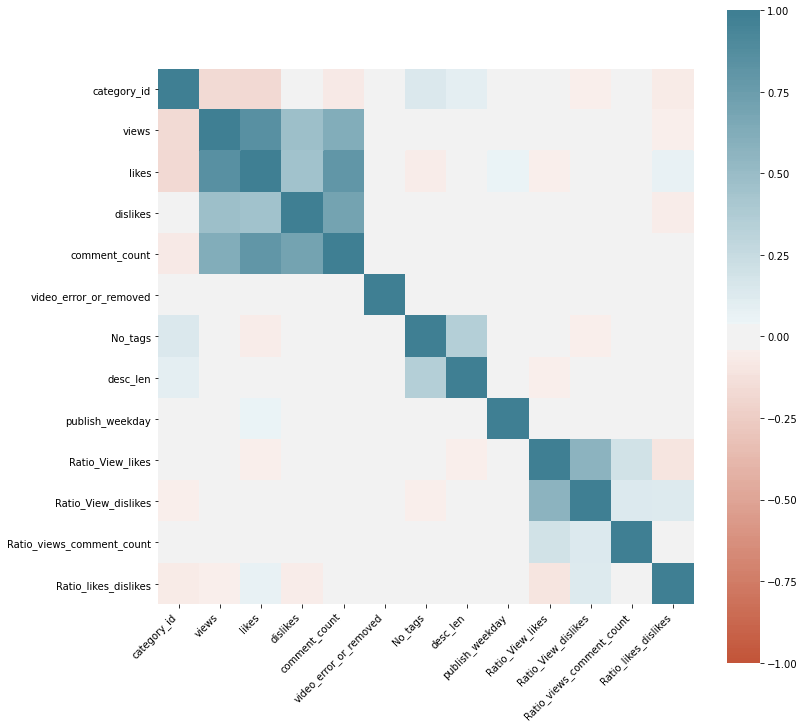

In [6]:
data = youtube

corr = data.corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [7]:
views=youtube.pop("views")
likes=youtube.pop("likes")
comments = youtube.pop("comment_count")

In [8]:
def train_compare(youtube, y):

    train, test, y_train, y_test = train_test_split(
        youtube, y, test_size=0.2, random_state=0)

    scaler = StandardScaler()
    train = scaler.fit_transform(train)
    test = scaler.transform(test)

    lin_regress = LinearRegression()
    lin_regress.fit(train, y_train)

    y_pred = lin_regress.predict(test)
    print('Root means score', np.sqrt(mean_squared_error(y_test, y_pred)))
    print("Result :", lin_regress.score(test, y_test))
    temp_df = {'True Labels': y_test, 'Predicted Labels': y_pred}
    result_lin = pd.DataFrame(data=temp_df)

    nEstimator = np.arange(100, 250, 50)
    depth = np.arange(10, 35, 5)

    model_rf = RandomForestRegressor()
    hyperParam = [{'n_estimators': nEstimator, 'max_depth': depth}]
    gsv = GridSearchCV(model_rf, hyperParam, cv=3, verbose=2,
                       scoring='neg_mean_squared_error', n_jobs=-1, refit=True)
    gsv.fit(train, y_train)

    model = gsv.best_estimator_
    y_pred = model.predict(test)
    print('Root means score', np.sqrt(mean_squared_error(y_test, y_pred)))
    print("Result :", model.score(test, y_test))
    temp_df = {'True Labels': y_test, 'Predicted Labels': y_pred}
    result_rf = pd.DataFrame(data=temp_df)

    fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)
    result_lin.iloc[::200].plot(kind='bar', figsize=(10, 8), ax=ax[0])
    result_rf.iloc[::200].plot(kind='bar', figsize=(10, 8), ax=ax[1])
    plt.show()

    return ((train, test, y_train, y_test), scaler, lin_regress, model)

Root means score 7051838.736727033
Result : 0.14328778444661283
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.2min finished


Root means score 760476.4690155119
Result : 0.9900367328373669


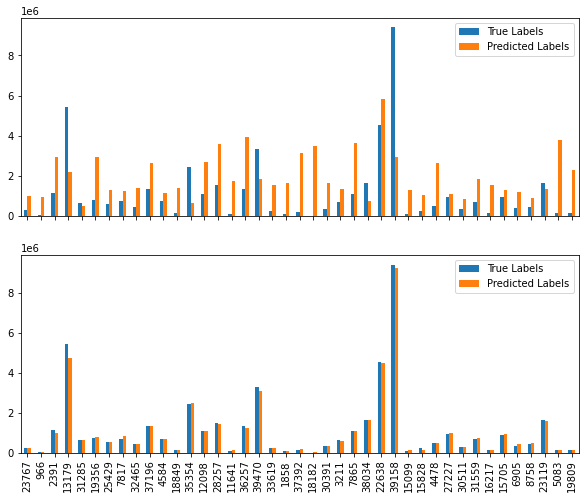

In [9]:
_ = train_compare(youtube, views)

Root means score 198327.43896879707
Result : 0.1631749343163591
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.0min finished


Root means score 19636.13419147621
Result : 0.991796842399177


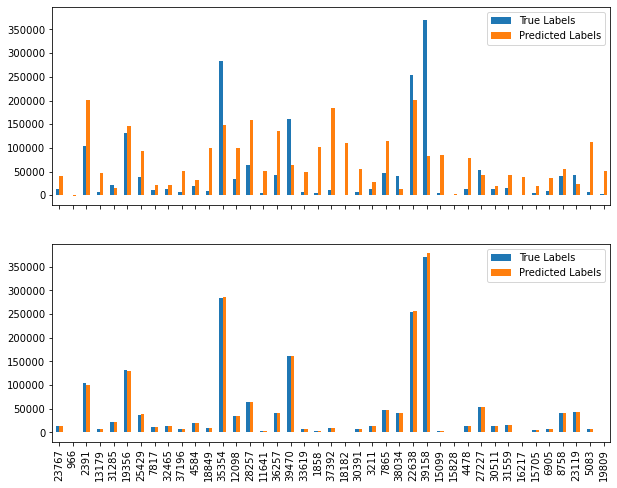

In [10]:
_ = train_compare(youtube, likes)

Root means score 18466.344798950595
Result : 0.7560255695630085
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.5min finished


Root means score 5463.5329730632475
Result : 0.978643525130079


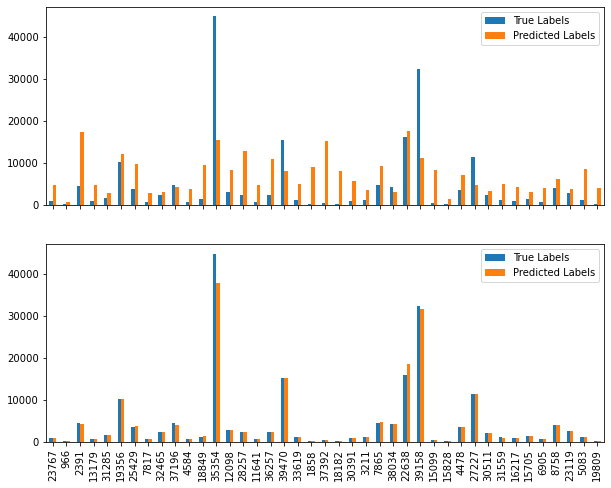

In [11]:
_ = train_compare(youtube, comments)